### Install required packages

In [20]:
INSTALL_REQUIREMENTS = False
if INSTALL_REQUIREMENTS:
    !pip --quiet install numpy
    !pip --quiet install unidecode
    !pip --quiet install matplotlib
    !pip --quiet install ipympl
    !pip --quiet install scikit-learn
    !pip --quiet install torch

### Import packages

In [21]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import os
import abc
import copy
import math
import random
import string
import unidecode
import pathlib
import requests
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.optim.optimizer import required
from torch.utils.data import DataLoader
from sklearn import model_selection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define constants

In [2]:
### GENERAL
SEED = 1269
DEVICE = 'cpu'  # 'cuda'
WEIGHT_KEYS = [
    'weight_ih',  # forward weight (Recurrent layer)
    'weight_hh',  # recurrent weight (Recurrent layer)
    'weight',  # forward weight (Linear layer)
]
### DATA
NAME_DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'
NAME_DATA_ZIP_FILE = 'data.zip'
NAME_DATA_NAMES_DIR = 'data/names/'
NAME_DATA_DIR = 'data/names'
TRAIN_SPLIT = 0.9
### TRAINING
HIDDEN_LAYER_DIMS = [256]
ENABLE_BIAS = True
NONLINEARITY = F.relu
N_EPOCHS = 40
BATCH_SIZE = 32
LOSSFUNC = nn.CrossEntropyLoss()
PROB_MODUL = 0.003
ALPHA_MODUL = 0.5
C2CORR = 1.0
### PLOTTING
SHADE_LOSS = True
COLOR_BACKPROP = 'gold'
COLOR_NODEPERT = 'turquoise'
COLOR_PRE_TRAIN = 'gray'
LEN_EPOCHS_ARRAY = N_EPOCHS + 1  # 
EPOCHS_ARRAY = np.linspace(1, LEN_EPOCHS_ARRAY, LEN_EPOCHS_ARRAY)

### Define local optimizer class

In [3]:
class LocalOptimizer(Optimizer):
    def __init__(self, named_params, lr=required):
        if lr is not required and lr < 0.0:
            raise ValueError(f'Invalid learning rate: {lr}')
        self.param_names, params = zip(*named_params)
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self, layer_idx, param_name='weight'):
        """Perform a single local optimization step."""
        loss = None
        for group in self.param_groups:
            param_index = self.param_names.index(f'layers.{layer_idx}.{param_name}')
            p = group['params'][param_index]
            dp = p.delta
            scaled_dp = group['lr'] * dp
            p.data.add_(scaled_dp)
        try:
            self._step_count += 1
        except AttributeError:
            pass
        return loss

### Define model classes

In [4]:
class BaseLayer:
    def __init__(self, in_features, out_features, nonlinearity):
        self.in_features = in_features
        self.out_features = out_features
        if nonlinearity is None:
            self.nonlinearity = lambda x: x
        else:
            self.nonlinearity = nonlinearity


class Linear(nn.Linear, BaseLayer):
    def __init__(self, in_features, out_features, nonlinearity=None,
                 bias=True):
        nn.Linear.__init__(self, in_features, out_features, bias=bias)
        BaseLayer.__init__(self, self.in_features, self.out_features,
                           nonlinearity=nonlinearity)

    def act(self, x, bias=True):
        if bias:
            a = nn.Linear.forward(self, x)
        else:
            a = F.linear(x, self.weight)
        return a

    def forward(self, x, bias=True):
        a = self.act(x, bias=bias)
        y = self.nonlinearity(a)
        return y


class Recurrent(nn.Module, BaseLayer):
    def __init__(self, in_features, out_features, nonlinearity=None, bias=True):
        nn.Module.__init__(self)
        BaseLayer.__init__(self, in_features, out_features,
                           nonlinearity=nonlinearity)
        self.weight_ih = nn.Parameter(torch.empty((
            self.out_features,
            self.in_features,
        )))
        self.weight_hh = nn.Parameter(torch.empty((
            self.out_features,
            self.out_features,
        )))
        if bias:
            self.bias_ih = nn.Parameter(torch.empty(self.out_features))
            self.bias_hh = nn.Parameter(torch.empty(self.out_features))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        stdv = 1.0 / math.sqrt(self.out_features)
        for p in self.parameters():
            nn.init.uniform_(p, -stdv, stdv)

    def extra_repr(self) -> str:
        in_features = self.in_features
        out_features = self.out_features
        return f'{in_features=}, {out_features=}'

    def act(self, x_t, h, bias=True):
        bias_ih = self.bias_ih if bias and self.bias_ih is not None else 0.
        bias_hh = self.bias_hh if bias and self.bias_hh is not None else 0.
        a = torch.matmul(x_t, self.weight_ih.t()) + bias_ih + \
            torch.matmul(h, self.weight_hh.t()) + bias_hh
        return a

    def forward(self, x_t, h, bias=True):
        a = self.act(x_t, h, bias=bias)
        y = self.nonlinearity(a)
        return y


class RNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_dims=[128], nonlinearity=F.relu, bias=True):
        super().__init__()
        self.layers = nn.ModuleList([
            Recurrent(input_size, hidden_dims[0], nonlinearity=nonlinearity,
                      bias=bias),
        ])
        for i in range(len(hidden_dims) - 1):
            self.layers.append(Recurrent(
                hidden_dims[i], hidden_dims[i + 1], nonlinearity=nonlinearity,
                bias=bias)
            )
        self.layers.append(Linear(hidden_dims[-1], output_size, bias=bias))
        self._init_delta()

    def _init_delta(self):
        for l in self.layers:
            for k in WEIGHT_KEYS:
                if (weight := getattr(l, k, None)) is not None:
                    weight.delta = nn.Parameter(torch.zeros(weight.shape))

    def forward(self, x, h=None, bias=True):
        batch_size = x.size(0)
        seq_len = x.size(1)
        rlayers = self.layers[:-1]
        outlayer = self.layers[-1]
        if h is None:
            h = [torch.zeros(batch_size, rl.out_features, device=x.device)
                 for rl in rlayers]
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            for rli, rl in enumerate(rlayers):
                x_t = h[rli] = rl(x_t, h[rli], bias=bias)
            y_t = outlayer(x_t, bias=bias)
            outputs.append(y_t)
        outputs = torch.stack(outputs, dim=1)
        return outputs, h
    
    def clone(self):
        model = copy.deepcopy(self)
        model._init_delta()
        return model

### Define general utils

In [5]:
def random_seed():
    return np.random.choice(2 ** 32)

def set_seed(seed=None):
    if seed is None:
        seed = random_seed()
    random.seed(seed)
    np.random.seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')

### Define data utils

In [6]:
def fetch_data():
    print('Downloading name data...')
    r = requests.get(NAME_DATA_URL)
    with open(NAME_DATA_ZIP_FILE, 'wb') as f:
        f.write(r.content)
    print('Extracting name data...')
    zf = zipfile.ZipFile(NAME_DATA_ZIP_FILE)
    for member in zf.filelist:
        if member.filename.startswith(NAME_DATA_NAMES_DIR) \
                and not member.filename.endswith('/'):
            fbasename = os.path.basename(member.filename)
            zipfileobj = zf.open(member)
            fp = os.path.join(NAME_DATA_DIR, fbasename)
            os.makedirs(os.path.dirname(fp), exist_ok=True)
            with open(fp, 'w+b') as f:
                shutil.copyfileobj(zipfileobj, f)
    os.remove(NAME_DATA_ZIP_FILE)


def name_to_tensor(name, ctoi):
    nchars = len(ctoi)
    tensor = torch.zeros(len(name), nchars)
    for i, char in enumerate(name):
        tensor[i][ctoi[char]] = 1
    return tensor


def collate_func(batch):
    batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
    input_tensors = []
    target_tensors = []
    for i, t in batch:
        input_tensors.append(i)
        target_tensors.append(t)
    padded_inputs = torch.nn.utils.rnn.pad_sequence(
        input_tensors, batch_first=True)
    targets = torch.tensor(target_tensors)
    return padded_inputs, targets


def load_name_data(ltoi, ctoi):
    inputs = []
    targets = []
    for file in os.listdir(NAME_DATA_DIR):
        with open(os.path.join(NAME_DATA_DIR, file)) as f:
            lang = file.split('.')[0]
            names = [unidecode.unidecode(line.rstrip()) for line in f]
            for name in names:
                try:
                    tensor = name_to_tensor(name, ctoi)
                    inputs.append(tensor)
                    targets.append(ltoi[lang])
                except KeyError:
                    pass
    return inputs, targets

### Define train utils

In [7]:
def correct_by_predictions(predictions, targets):
    _, predictions_max = torch.max(predictions, dim=1)
    correct = (predictions_max == targets).sum().item()
    return correct, predictions_max


def generate_init_data(model, train_loader, val_loader, lossfunc):
    set_seed(SEED)
    print('Generating initial prediction, loss, etc. data...')
    model = model.to(DEVICE)
    with torch.no_grad():
        all_train_losses = []
        all_train_corrects = []
        for train_inputs, train_targets in train_loader:
            train_inputs = train_inputs.to(DEVICE)
            train_targets = train_targets.to(DEVICE)
            trainpreds, _ = model(train_inputs)
            trainloss = lossfunc(
                trainpreds[:, -1, :], train_targets)
            train_correct, _ = correct_by_predictions(
                trainpreds[:, -1, :],
                train_targets,
            )
            all_train_losses.append(trainloss.item())
            all_train_corrects.append(train_correct)
        all_val_predictions = []
        all_val_targets = []
        all_val_losses = []
        all_val_corrects = []
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(DEVICE)
            val_targets = val_targets.to(DEVICE)
            val_preds, _ = model(val_inputs)
            val_loss = lossfunc(val_preds[:, -1, :], val_targets)
            val_correct, predsmax = correct_by_predictions(
                val_preds[:, -1, :],
                val_targets,
            )
            all_val_predictions.extend(predsmax.cpu().numpy())
            all_val_targets.extend(val_targets.cpu().numpy())
            all_val_losses.append(val_loss.item())
            all_val_corrects.append(val_correct)
    tloss_initial = np.mean(all_train_losses)
    vloss_initial = np.mean(all_val_losses)
    tcorrects_initial = all_train_corrects[-1]
    vcorrects_initial = all_val_corrects[-1]
    return tloss_initial, vloss_initial, tcorrects_initial, vcorrects_initial


@torch.no_grad()
def eval_model(model, lossfunc, data_loader, DEVICE):
    model.eval()
    blosses = []
    bcorrects = []
    for batch in data_loader:
        inputs, targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        predictions = model(inputs)
        if isinstance(model, RNN):
            predictions = predictions[0][:, -1, :]
        loss = lossfunc(predictions, targets)
        blosses.append(loss.item())
        correct, _ = correct_by_predictions(predictions, targets)
        bcorrects.append(correct)
    return blosses, bcorrects

def train_backprop(model, n_epochs, train_loader, val_loader, lossfunc, optimizer):
    tlosses = []
    vlosses = []
    tcorrects = []
    vcorrects = []
    for _ in range(n_epochs):
        btlosses = []
        btcorrects = []
        model.train()
        for batch in train_loader:
            inputs, targets = batch
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            predictions = model(inputs)
            if isinstance(model, RNN):
                predictions = predictions[0][:, -1, :]
            loss = lossfunc(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            btlosses.append(loss.item())
            _, max_predicted = torch.max(predictions, dim=1)
            correct = (max_predicted == targets).sum().item()
            btcorrects.append(correct)
        tlosses.append(btlosses)
        tcorrects.append(btcorrects)
        bvlosses, bvcorrects = eval_model(model, lossfunc, val_loader, DEVICE)
        vlosses.append(bvlosses)
        vcorrects.append(bvcorrects)
    return tlosses, vlosses, tcorrects, vcorrects

def train_nodepert(model, n_epochs, train_loader, val_loader, lossfunc, optimizer, bias_in_post_activity=True):
    model.train()
    tlosses = []
    vlosses = []
    tcorrects = []
    vcorrects = []
    for _ in range(n_epochs):
        btlosses = []
        btcorrects = []
        for batch in train_loader:
            inputs, targets = batch
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs, _ = model(inputs)
            outputs = outputs[:, -1, :]
            loss = lossfunc(outputs, targets)
            layers = model.layers
            batch_size = inputs.size(0)
            n_timesteps = inputs.size(1)
            rlayers = [l for l in layers if isinstance(l, Recurrent)]
            h = [torch.zeros(batch_size, rl.out_features, device=inputs.device) for rl in rlayers]
            for t in range(n_timesteps):
                x_t = inputs[:, t, :]
                for li, l in enumerate(layers):
                    for k in WEIGHT_KEYS:
                        if (w := getattr(l, k, None)) is not None:
                            largs = [x_t]
                            if isinstance(l, Recurrent):
                                largs.append(h[li])
                            a = l.act(*largs, bias=bias_in_post_activity)
                            num_neurons = l.out_features
                            num_neurons_to_perturb = math.ceil(PROB_MODUL * num_neurons)
                            batch_indices = torch.randint(0, num_neurons, size=(batch_size, num_neurons_to_perturb))
                            noise = torch.rand(batch_size, num_neurons_to_perturb)
                            modul = ALPHA_MODUL * (-1.0 + 2 * noise)
                            perturbations = torch.zeros(batch_size, num_neurons)
                            perturbations.scatter_add_(1, batch_indices, modul)
                            a_perturbed = a + perturbations
                            if k == 'weight_hh':
                                vj = h[li]
                            else:
                                vj = x_t
                            dw = C2CORR * perturbations.t() @ vj
                            if t == 0:
                                w.t_deltas = []
                            w.t_deltas.append(dw)
                    if li < len(rlayers):
                        x_t = h[li] = l.nonlinearity(a_perturbed)
                if t == n_timesteps - 1:
                    assert isinstance(l, Linear)
                    assert l is layers[-1]
                    # Calculate loss with perturbations
                    y_t = l.nonlinearity(a_perturbed)
                    loss_w_perturb = lossfunc(y_t, targets)
                    # Update weights
                    for li, l in enumerate(layers):
                        for k in WEIGHT_KEYS:
                            if (w := getattr(l, k, None)) is not None:
                                assert len(w.t_deltas) == n_timesteps
                                etrace = sum(w.t_deltas)
                                netloss = loss_w_perturb - loss
                                dw = - etrace * netloss
                                w.delta = dw
                                optimizer.step(layer_idx=li, param_name=k)
            btlosses.append(loss.item())
            _, max_preds = torch.max(outputs, dim=1)
            correct = (max_preds == targets).sum().item()
            btcorrects.append(correct)
        tlosses.append(btlosses)
        tcorrects.append(btcorrects)
        bvlosses, bvcorrects = eval_model(model, lossfunc, val_loader, DEVICE)
        vlosses.append(bvlosses)
        vcorrects.append(bvcorrects)
    return tlosses, vlosses, tcorrects, vcorrects

### Define plot utils

In [8]:
def plot(ax, x, y, y0_prepend=None, shaded=True, logscale=False, y_divider=None, **axkwargs):
    mean_y = np.mean(y, axis=-1)
    prepend_y0 = y0_prepend is not None
    if prepend_y0:
        mean_y = np.concatenate([[y0_prepend], mean_y])
    if y_divider:
        mean_y /= y_divider
    ax.plot(x, mean_y, **axkwargs)
    ax.grid('on')
    if shaded:
        std_y = np.std(y, axis=-1)
        if prepend_y0:
            std_y = np.concatenate([[0.], std_y])
        if y_divider:
            std_y /= y_divider
        ylow = mean_y - std_y
        yhigh = mean_y + std_y
        # Avoid infinite value problems due to ax.set_yscale('log'):
        # https://github.com/matplotlib/matplotlib/issues/8623#issuecomment-301606299
        where = ((ylow > 0) & (yhigh > 0)) if logscale else None
        ax.fill_between(x, ylow, yhigh, alpha=0.2, where=where, color=axkwargs.get('color'))

### Fetch data

In [9]:
fetch_data()

Extracting name data...


### Load training data

In [10]:
set_seed(SEED)
ctoi = {letter: i for i, letter in enumerate(string.ascii_letters + " .,:;-'")}
ltoi = {
    file_name.split('.')[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(NAME_DATA_DIR))
}
print('Loading training and validation data...')
all_inputs, all_targets = load_name_data(ltoi, ctoi)
train_idx, val_idx = model_selection.train_test_split(range(len(all_targets)), test_size=(1 - TRAIN_SPLIT), shuffle=True)
train_dataset = [(all_inputs[i], all_targets[i]) for i in train_idx]
val_dataset = [(all_inputs[i], all_targets[i]) for i in val_idx]
train_dl = DataLoader(train_dataset, BATCH_SIZE, collate_fn=collate_func, shuffle=True)
val_dl = DataLoader(val_dataset, BATCH_SIZE, collate_fn=collate_func, shuffle=False)

Random seed 1269 has been set.
Loading training and validation data...


### Define model

In [11]:
input_size = len(ctoi)  # number of characters
output_size = len(ltoi)  # number of languages/categories
model = RNN(
    input_size=input_size,
    output_size=output_size,
    hidden_dims=HIDDEN_LAYER_DIMS,
    nonlinearity=NONLINEARITY,
    bias=ENABLE_BIAS,
)

### Generate pre-training data (initial)

In [12]:
tloss_initial, vloss_initial, tcorrects_initial, vcorrects_initial = generate_init_data(model=model, train_loader=train_dl, val_loader=val_dl, lossfunc=LOSSFUNC)

Random seed 1269 has been set.
Generating initial prediction, loss, etc. data...


### Train w backpropagation

In [13]:
backprop_model = copy.deepcopy(model)
optim_backprop = Adam(params=backprop_model.parameters(), lr=1e-3)
tlosses_backprop, vlosses_backprop, tcorrects_backprop, vcorrects_backprop = train_backprop(model=backprop_model, n_epochs=N_EPOCHS, train_loader=train_dl, val_loader=val_dl, lossfunc=LOSSFUNC, optimizer=optim_backprop)

### Train w node perturbation

In [14]:
nodepert_model = copy.deepcopy(model)
optim_local = LocalOptimizer(named_params=nodepert_model.named_parameters(), lr=0.1)
tlosses_nodepert, vlosses_nodepert, tcorrects_nodepert, vcorrects_nodepert = train_nodepert(model=nodepert_model, n_epochs=N_EPOCHS, train_loader=train_dl, val_loader=val_dl, lossfunc=LOSSFUNC, optimizer=optim_local, bias_in_post_activity=ENABLE_BIAS)

### Plot loss

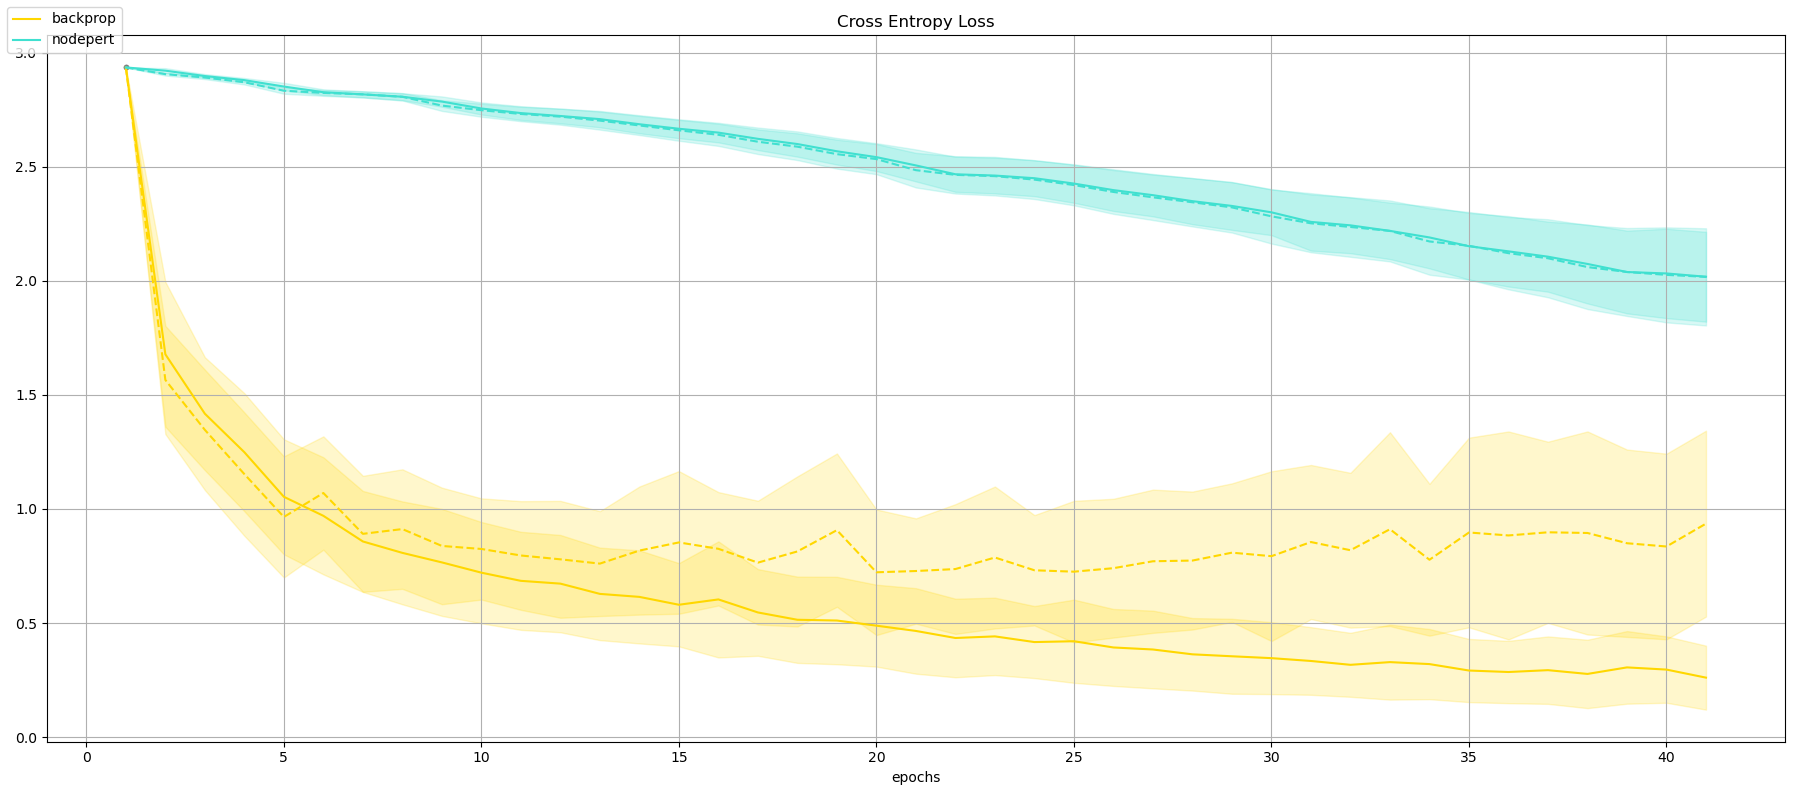

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.set_title('Cross Entropy Loss')
ax.set_xlabel('epochs')
# Initial losses
ax.plot(1, tloss_initial, '.', color=COLOR_PRE_TRAIN)
ax.plot(1, vloss_initial, '.', color=COLOR_PRE_TRAIN)
# Backprop
plot(ax, EPOCHS_ARRAY, tlosses_backprop, y0_prepend=tloss_initial, color=COLOR_BACKPROP, label='backprop', shaded=SHADE_LOSS);
plot(ax, EPOCHS_ARRAY, vlosses_backprop, y0_prepend=vloss_initial, color=COLOR_BACKPROP, linestyle='--', shaded=SHADE_LOSS);
# Nodepert
plot(ax, EPOCHS_ARRAY, tlosses_nodepert, y0_prepend=tloss_initial, color=COLOR_NODEPERT, label='nodepert', shaded=SHADE_LOSS);
plot(ax, EPOCHS_ARRAY, vlosses_nodepert, y0_prepend=vloss_initial, color=COLOR_NODEPERT, linestyle='--', shaded=SHADE_LOSS);
handles, _ = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc='upper left')
fig.tight_layout()

### Plot accuracy

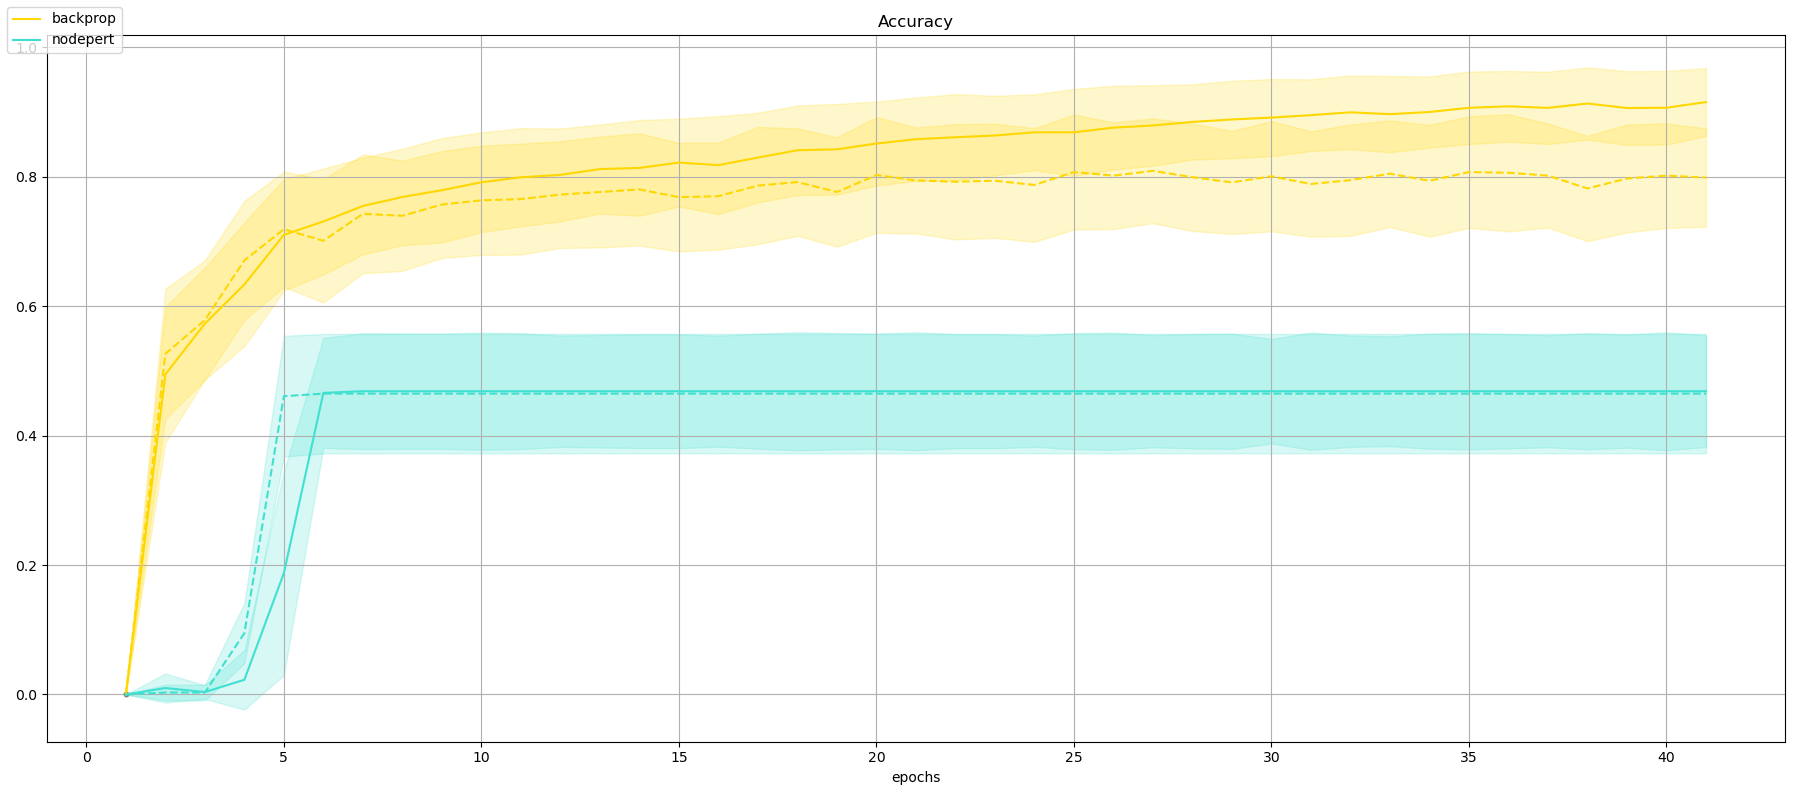

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.set_title('Accuracy')
ax.set_xlabel('epochs')
# Initial losses
tcorrect_initial = tcorrects_initial / BATCH_SIZE
vcorrect_initial = vcorrects_initial / BATCH_SIZE
ax.plot(1, tcorrect_initial, '.', color=COLOR_PRE_TRAIN)
ax.plot(1, vcorrect_initial, '.', color=COLOR_PRE_TRAIN)
# Backprop
plot(ax, EPOCHS_ARRAY, tcorrects_backprop, y0_prepend=tcorrects_initial, y_divider=BATCH_SIZE, color=COLOR_BACKPROP, label='backprop', shaded=SHADE_LOSS);
plot(ax, EPOCHS_ARRAY, vcorrects_backprop, y0_prepend=vcorrects_initial, y_divider=BATCH_SIZE, color=COLOR_BACKPROP, linestyle='--', shaded=SHADE_LOSS);
# Nodepert
plot(ax, EPOCHS_ARRAY, tcorrects_nodepert, y0_prepend=tcorrects_initial, y_divider=BATCH_SIZE, color=COLOR_NODEPERT, label='nodepert', shaded=SHADE_LOSS);
plot(ax, EPOCHS_ARRAY, vcorrects_nodepert, y0_prepend=vcorrects_initial, y_divider=BATCH_SIZE, color=COLOR_NODEPERT, linestyle='--', shaded=SHADE_LOSS);
handles, _ = ax.get_legend_handles_labels()
fig.legend(handles=handles, loc='upper left')
fig.tight_layout()